<a href="https://colab.research.google.com/github/kjspring/x-ray-pneumonia-prediction-app/blob/main/WESAD_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!git clone https://github.com/kjspring/stress-detection-wearable-devices.git

In [3]:
#!git clone https://github.com/kjspring/pyEDA.git

In [4]:
#! git clone https://github.com/neuropsychology/NeuroKit

In [5]:
! pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Exploratory data analysis of dataset

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import pickle
#from pyEDA.main import *
import neurokit2 as nk

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
! ls /content/drive/MyDrive/stress-prediction

cvxEDA.py  data  data_wrangling.py  files  __pycache__	WESAD


In [9]:
#! cd /content/drive/MyDrive/stress-prediction/ # Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

## Open and clean up raw data
The data for swell and wsead is stored in seperate folders. Within each of these is a subfolder holding the eda, rri, and Labels folders

In [10]:
original_dir = os.path.join(PATH, 'original')
org_WESAD_dir = os.path.join(original_dir, 'WESAD')
#process_eda_swell_files = glob.glob(os.path.join(org_WESAD_dir, "*.pkl"))
print(org_WESAD_dir)

/content/drive/MyDrive/stress-prediction/data/original/WESAD


In [44]:
class SubjectData:
# https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
    def __init__(self, main_path, subject_number):
        #print(main_path)
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']
        self.labels[self.labels > 4] = 0

    def get_wrist_data(self):
        data = self.data['signal']['chest']
        data.update({'RSP': self.data['signal']['chest']['Resp']})
        data.update({'ECG' : self.data['signal']['chest']['ECG']})
        data.update({'EMG' : self.data['signal']['chest']['EMG']})
        data.update({'HRV' : self.data['signal']['wrist']['BVP']})
        data['labels'] = self.labels
        #del data['BVP']
        # Store the specific labels for each measurement
        #for key in data.keys():
          #batch_no = len(self.labels)//len(data[key])
          #labels = self.labels[1::batch_no] #extract the specific labels
          #data[key]['labels'] = labels
          #.update({'labels': labels}) # save under measurement
               
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

        return results


In [45]:
def subject_data_import(directory):
  import regex as re

  regex = re.compile(r'\d+')
  subject_li = []
  ext = '.pkl' # pickle extension
  # Walk through data directory and only return with specific extension
  for path, dirc, files in os.walk(directory):
    for name in files:
      if name.endswith(ext):
        subject_number = regex.findall(name) # Extract the subject number
        subject_li.append(SubjectData(directory, int(subject_number[0]))) # Create SubjectData object

  return subject_li

In [46]:
# Store all subject data into a list of SubjectData objects for easier use
wesad_sd_li = subject_data_import(org_WESAD_dir)


## Dictionary analysis


In [47]:
# Extract wrist data
wesad_data_li = [ f.get_wrist_data() for f in wesad_sd_li ]

In [48]:
wesad_data_li[0].keys()

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'RSP', 'HRV', 'labels'])

In [49]:
# Grab only subject 4
#S4 = SubjectData(org_WESAD_dir, 4)
#S4_wrist = S4.get_wrist_data() # get wrist data

In [88]:
# Neurokit2

# process the data (filter, find peaks, ect.)
processed_data, info = nk.bio_process(eda=wesad_data_li[0]['EDA'],
                                      sampling_rate=120)

In [94]:
processed_data['EDA_Clean']

0          0.716029
1          0.715708
2          0.715407
3          0.715128
4          0.714874
             ...   
3847195    1.718332
3847196    1.718766
3847197    1.719168
3847198    1.719533
3847199    1.719859
Name: EDA_Clean, Length: 3847200, dtype: float64

In [89]:
print(len(wesad_data_li[0]['EDA']))
print(len(processed_data['EDA_Clean'].dropna()))

3847200
3847200


In [95]:
processed_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   EDA_Raw           3847200 non-null  float64
 1   EDA_Clean         3847200 non-null  float64
 2   EDA_Tonic         3847200 non-null  float64
 3   EDA_Phasic        3847200 non-null  float64
 4   SCR_Onsets        3847200 non-null  int64  
 5   SCR_Peaks         3847200 non-null  int64  
 6   SCR_Height        3847200 non-null  float64
 7   SCR_Amplitude     3847200 non-null  float64
 8   SCR_RiseTime      3847200 non-null  float64
 9   SCR_Recovery      3847200 non-null  int64  
 10  SCR_RecoveryTime  3847196 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 322.9 MB


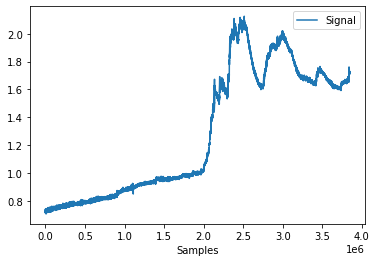

In [96]:
nk.signal_plot(processed_data['EDA_Clean'])

In [97]:
wesad_sd_li[0].labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

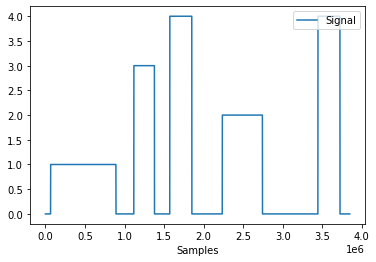

In [98]:
nk.signal_plot(wesad_sd_li[0].labels)

In [99]:
len(wesad_sd_li[0].labels)

3847200

array([[<Axes: title={'center': '0'}>]], dtype=object)

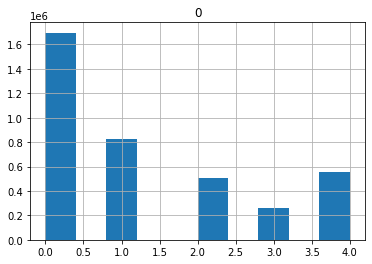

In [100]:
pd.DataFrame(wesad_sd_li[0].labels).hist()

In [101]:
# The labels data is at 700Hz (700 records a second)
# EDA data is sampled at 4Hz (4 records a second)
# To get the accurate labels, you should take slices of the labels data
## subsample the labels array and keep every 175th label
labels = wesad_sd_li[0].labels[1::175]

In [102]:
len(labels)

21984

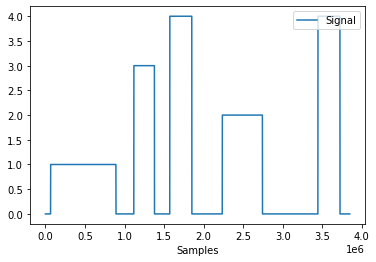

In [103]:
nk.signal_plot(wesad_sd_li[0].labels)

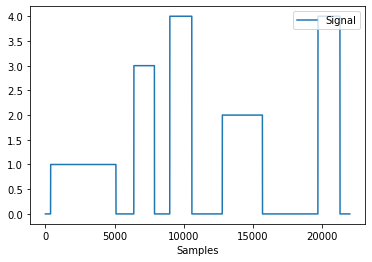

In [104]:
nk.signal_plot(labels)

In [105]:
condition_list = [0, 1, 2, 3, 4]
events = nk.events_find(event_channel=labels,
                        threshold=0,
                        threshold_keep="above",
                        event_conditions=condition_list)
events

{'onset': array([  372,  6384,  8980, 12772, 19680]),
 'duration': array([4720, 1488, 1592, 2900, 1592]),
 'label': array(['1', '2', '3', '4', '5'], dtype='<U21'),
 'condition': [0, 1, 2, 3, 4]}

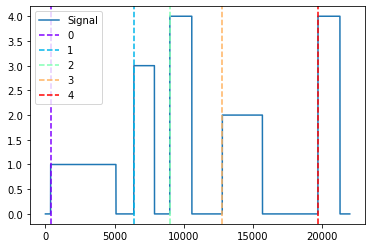

In [106]:
plot = nk.events_plot(events, labels)

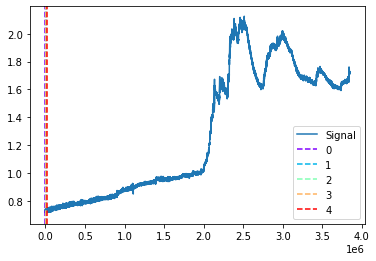

In [107]:
plot = nk.events_plot(events, processed_data['EDA_Clean'])

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


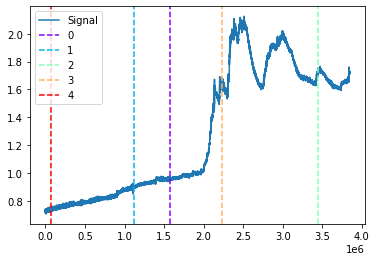

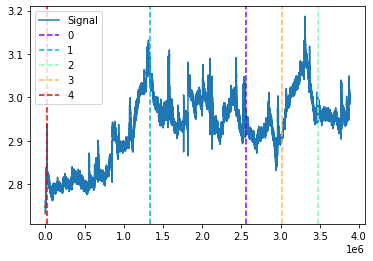

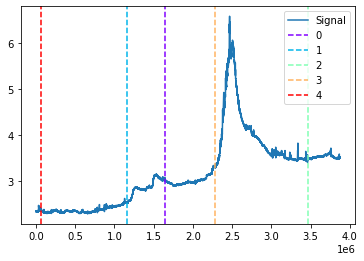

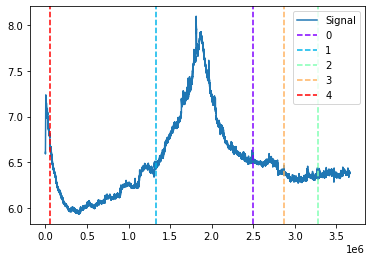

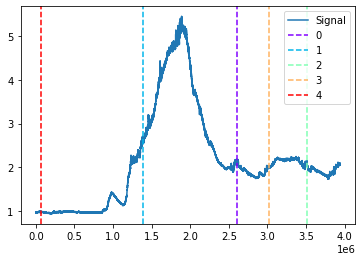

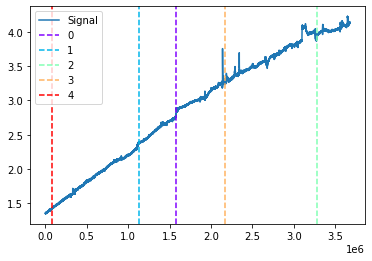

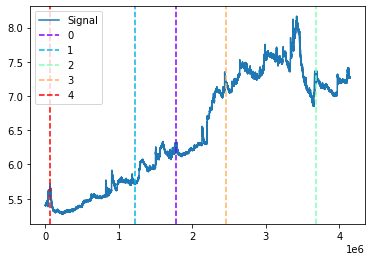

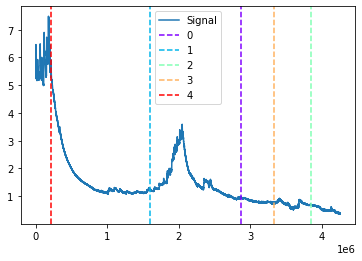

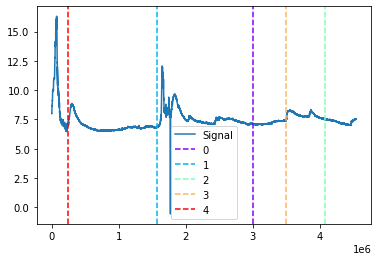

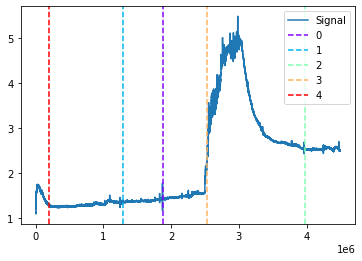

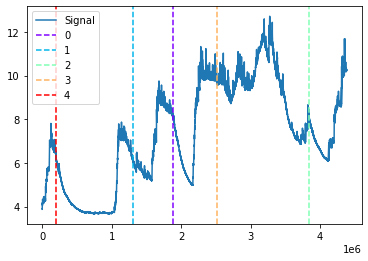

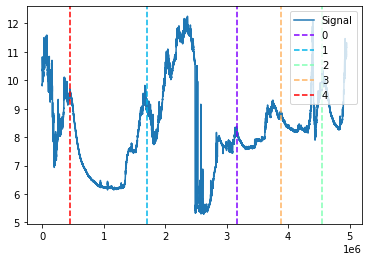

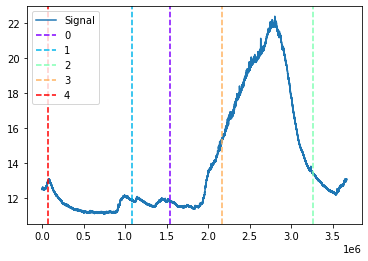

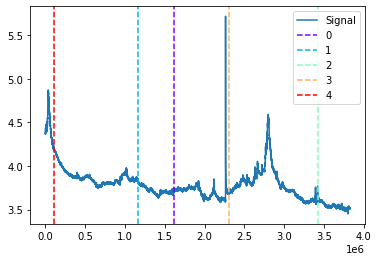

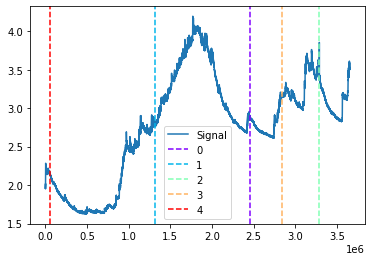

In [108]:
def plot_events(data, condition_list):
  #numplots = round(len(wesad_data_li) / 4)
  #fig, axes = plt.subplots(4, numplots, figsize=(10,10), sharex=True, sharey=True)

  # iterate over the SubjectData objects stored in wesad_data_li
  for idx, subject in enumerate(data):

    batch_no = len(data[idx]['labels'])//len(data[idx]['EDA'])
    labels = wesad_sd_li[idx].labels[1::batch_no]
    processed_data, info = nk.bio_process(eda=subject['EDA'], sampling_rate=120)

    #condition_list = [0, 1, 2, 3, 4]
    
    events = nk.events_find(event_channel=labels,
                            threshold=0,
                            threshold_keep="above",
                            event_conditions=condition_list)
    
    plot = nk.events_plot(events, processed_data['EDA_Clean'])

  # spacing between subplots
  #fig.tight_layout()

condition_list = ['Undefined', 'Baseline', 'Stress', 'Ameusement', 'Meditation']
plot_events(wesad_data_li, condition_list)

In [109]:
# Event-related analysis
data_clean, info = nk.bio_process(eda=wesad_data_li[0]['EDA'],
                                  sampling_rate=1200)

# data_clean = [ f.get_wrist_data() for f in wesad_sd_li ]


In [110]:
epochs = nk.epochs_create(data_clean, events, sampling_rate = 120,
                          epochs_start=-1, epochs_end=3)

In [111]:
# Visualize a subset of signals
#data_clean.iloc[['ECG_Rate']].plot(subplots=True)

In [112]:
data_clean.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   EDA_Raw           3847200 non-null  float64
 1   EDA_Clean         3847200 non-null  float64
 2   EDA_Tonic         3847200 non-null  float64
 3   EDA_Phasic        3847200 non-null  float64
 4   SCR_Onsets        3847200 non-null  int64  
 5   SCR_Peaks         3847200 non-null  int64  
 6   SCR_Height        3847200 non-null  float64
 7   SCR_Amplitude     3847200 non-null  float64
 8   SCR_RiseTime      3847200 non-null  float64
 9   SCR_Recovery      3847200 non-null  int64  
 10  SCR_RecoveryTime  3847199 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 322.9 MB


In [123]:
df = nk.bio_analyze(epochs, sampling_rate=120)
df

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
1,1,0,372,0.003062,0,NaN,NaN,NaN,NaN
2,2,1,6384,0.002060,0,NaN,NaN,NaN,NaN
3,3,2,8980,0.001165,0,NaN,NaN,NaN,NaN
4,4,3,12772,0.001894,0,NaN,NaN,NaN,NaN
5,5,4,19680,0.000756,0,NaN,NaN,NaN,NaN


<Axes: xlabel='Condition', ylabel='EDA_Peak_Amplitude'>

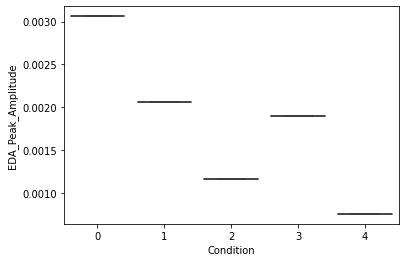

In [124]:
import seaborn as sns
sns.boxplot(x="Condition", y="EDA_Peak_Amplitude", data=df)

In [133]:
events = nk.events_find(event_channel=y_train,
                        threshold=0,
                        threshold_keep="above",
                        event_conditions=condition_list)
events

{'onset': array([  65000, 1117100, 1571400, 2234999, 3443900]),
 'duration': array([826000, 260400, 278600, 507500, 278600]),
 'label': array(['1', '2', '3', '4', '5'], dtype='<U21'),
 'condition': ['Undefined', 'Baseline', 'Stress', 'Ameusement', 'Meditation']}

In [ ]:
# LTSM Model

for subject in wesad_data_li:
  
  from keras.models import Sequential
  from keras.layers import LSTM, Dense

  # Clean the data
  data_clean, info = nk.bio_process(eda=subject['EDA'],
                                  sampling_rate=1200)

  # Identify the event onset
  events = nk.events_find(event_channel=subject['labels'],
                        threshold=0,
                        threshold_keep="above",
                        event_conditions=condition_list)
  
  # Split the train and test datasets
  from sklearn.model_selection import train_test_split
  #X_train, Y_train, X_test, Y_test = train_test_split(data_clean['EDA_Clean'],
  #                                                    test_size=0.2,
  #                                                    shuffle=False)
  
  X_train = data_clean['EDA_Clean'][:events['onset'][2]]
  X_test = data_clean['EDA_Clean'][events['onset'][2]:]
  Y_train = subject['labels'][:events['onset'][2]]
  Y_test = subject['labels'][events['onset'][2]:]

  # Timeseries generator
  from keras.preprocessing.sequence import TimeSeriesGenterator
X_train 

In [147]:
from keras.preprocessing.sequence import TimeseriesGenerator

X_train = np.array(data_clean['EDA_Clean'][:events['onset'][2]])
X_test = np.array(data_clean['EDA_Clean'][events['onset'][2]:])
y_train = np.array(wesad_data_li[0]['labels'][:events['onset'][2]])
y_test = np.array(wesad_data_li[0]['labels'][events['onset'][2]:])

generator = TimeseriesGenerator(X_train, 
                                y_train,
                                length=1200,
                                batch_size=32)

In [151]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
sequence_length = 1200
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model using the generator
model.fit_generator(generator, epochs=2)

28357/49069 [================>.............] - ETA: 2:44:56 - loss: nan

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-151-49b7504a79d1>", line 12, in <module>
    model.fit_generator(generator, epochs=2)
  File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2604, in fit_generator
    return self.fit(
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1650, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 880, in __call__
    result 

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model on the testing set
test_generator = TimeseriesGenerator(test_data, test_data, length=sequence_length, batch_size=1)
test_loss = model.evaluate_generator(test_generator)
print('Test loss:', test_loss)